In [76]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


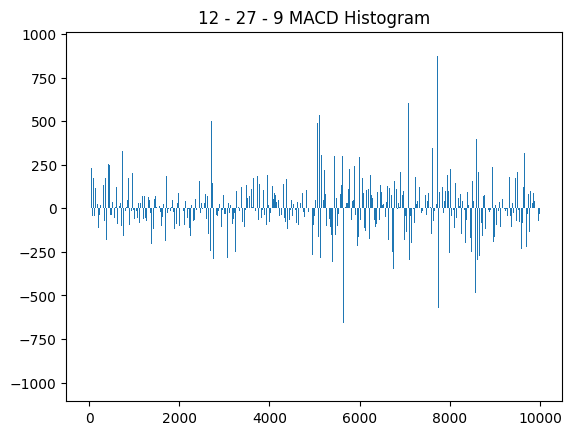

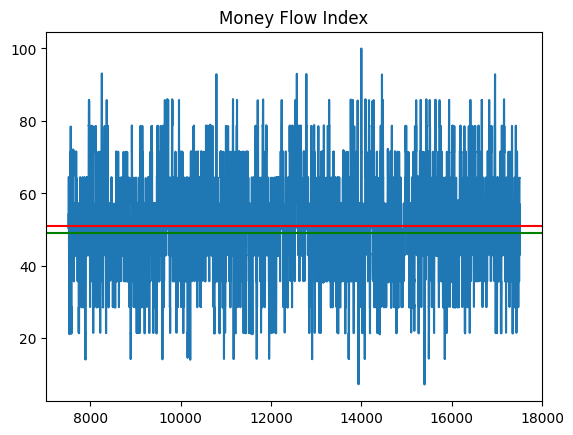

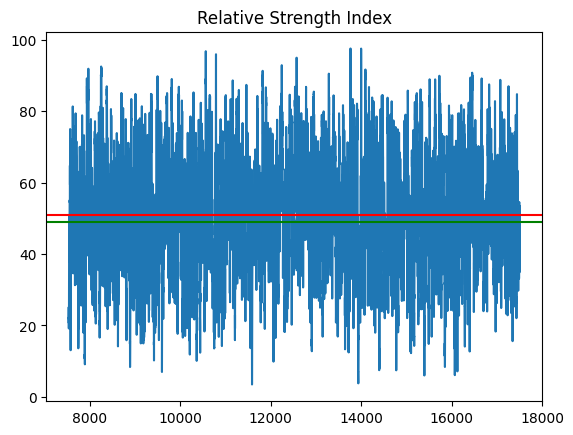

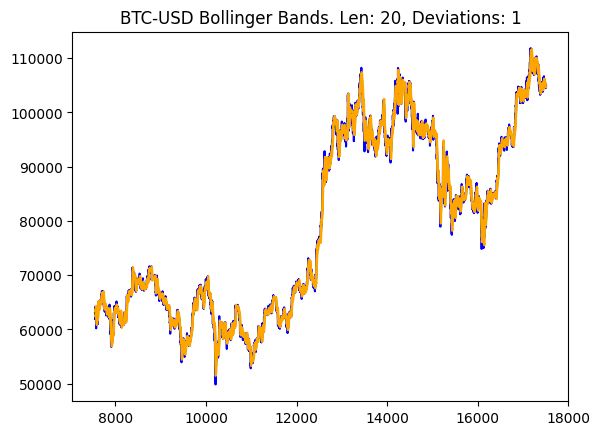

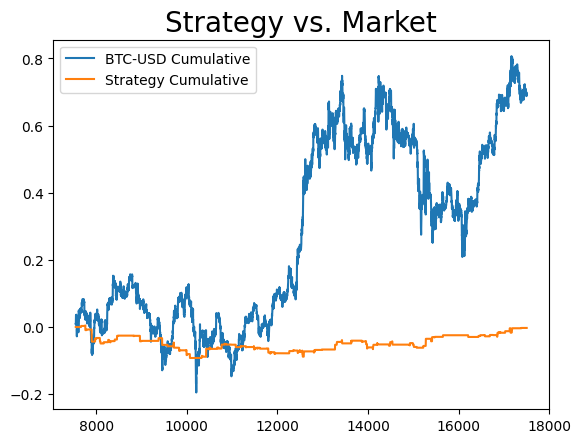

In [77]:
TICKER = 'BTC-USD'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
MFI_LENGTH = 14
MFI_OVERBOUGHT = 51
MFI_OVERSOLD = 49
RSI_LENGTH = 14
RSI_OVERBOUGHT = 51
RSI_OVERSOLD = 49
BB_LEN = 20
DEVS = 1

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MFI(df, length=MFI_LENGTH):

    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']
 
    # initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()

    # add money flow column
    df['MFI'] = 100 - (100 / (1 + mfr))

    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(MFI_OVERBOUGHT, color='red')
    plt.axhline(MFI_OVERSOLD, color='green')
    plt.title('Money Flow Index');
        
    return df.dropna()

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['BB_SMA'], color='green')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    
    return df

def add_MFI_strategy(df, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

def add_RSI_strategy(df, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], -1, 
        np.where(df['Close'] < df['Lower_Band'], 1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['MFI_Strategy'] + df['RSI_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 4, 1, 
                     np.where(df['Full_Strategy'] == -4, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', 'Strategy Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_RSI(df)
    df = add_BB(df)
    df = add_MACD_strategy(df)
    df = add_MFI_strategy(df)
    df = add_RSI_strategy(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df[['Close', 'MACD_hist', 'MFI', 'RSI', 'Upper_Band', 'Lower_Band', 'MACD_Strategy', 'MFI_Strategy', 'RSI_Strategy', 'BB_Strategy', 'Full_Strategy', 'Strategy', 'Asset_Returns', 'Strategy_Returns']]

df = main()

In [78]:
df

Price,Close,MACD_hist,MFI,RSI,Upper_Band,Lower_Band,MACD_Strategy,MFI_Strategy,RSI_Strategy,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
7550,61914.695312,-45.733668,35.802016,37.785556,63461.774403,62552.104112,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
7551,62482.144531,-25.757235,42.918822,41.701009,63439.136455,62504.463936,-1.0,1.0,1.0,1.0,2.0,0,0.009165,0.000000
7552,62379.781250,-14.260753,50.071457,44.060501,63405.167189,62447.392186,-1.0,1.0,1.0,1.0,2.0,0,0.007512,0.000000
7553,62986.125000,36.981509,57.192765,55.069290,63364.448863,62440.132777,-1.0,0.0,1.0,1.0,1.0,0,0.017305,0.000000
7554,62777.230469,57.924361,57.200759,50.481136,63314.834284,62424.038373,1.0,-1.0,-1.0,0.0,-1.0,0,0.013931,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17500,104497.164062,-20.258467,42.881423,34.836845,105229.321272,104732.940447,1.0,0.0,1.0,1.0,3.0,0,0.687760,-0.002767
17501,104553.078125,-29.906073,50.020833,40.786528,105213.104324,104688.929269,-1.0,1.0,1.0,1.0,2.0,0,0.688663,-0.002767
17502,104697.125000,-23.530548,57.164634,44.867788,105196.441651,104665.393505,-1.0,0.0,1.0,1.0,1.0,0,0.690990,-0.002767
17503,104954.742188,0.127242,64.315789,48.253675,105202.569592,104675.471815,-1.0,-1.0,1.0,0.0,-1.0,0,0.695151,-0.002767
